In [134]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm
from torchsummary import summary

In [135]:
train_data = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
test_data = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)

In [136]:
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

In [137]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [138]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

In [139]:
pd.Series(y_train).value_counts()

0    57892
4     5182
2     4676
1     1797
3      496
Name: count, dtype: int64

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Prepare the data

In [141]:
class ECGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [142]:
train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)
test_dataset = ECGDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [143]:
len(train_loader), len(test_loader)

(1095, 343)

In [144]:
next(iter(train_loader))

[tensor([[1.0000, 0.8582, 0.4627,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.5519, 0.2116,  ..., 0.0000, 0.0000, 0.0000],
         [0.9878, 0.4857, 0.5347,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.9221, 0.7607, 0.1002,  ..., 0.0000, 0.0000, 0.0000],
         [0.7024, 0.2147, 0.0094,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8440, 0.4680,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
         4, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])]

In [145]:
class ECGConvNet(nn.Module):
    def __init__(self):
        super(ECGConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        dummy_input = torch.zeros(1, 1, 188)  # Correct shape
        dummy_output = self._forward_conv(dummy_input)
        self.fc_input_size = dummy_output.view(-1).size(0)
        
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 5)  # 5 classes
    
    def _forward_conv(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        return x
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [153]:
model = ECGConvNet()
model.to(device)

# Set up the criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [154]:
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0.0, 0
    for signals, labels in train_loader:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / len(train_dataset))
    
    # Validation phase
    model.eval()
    val_loss, correct_val = 0.0, 0
    with torch.no_grad():
        for signals, labels in val_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / len(val_dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/50, Train Loss: 0.6021, Val Loss: 0.3612, Train Acc: 0.7428, Val Acc: 0.7645
Epoch 2/50, Train Loss: 0.3392, Val Loss: 0.2812, Train Acc: 0.8560, Val Acc: 0.9153
Epoch 3/50, Train Loss: 0.2625, Val Loss: 0.2553, Train Acc: 0.8858, Val Acc: 0.9135
Epoch 4/50, Train Loss: 0.2139, Val Loss: 0.2282, Train Acc: 0.9047, Val Acc: 0.9286
Epoch 5/50, Train Loss: 0.1803, Val Loss: 0.2567, Train Acc: 0.9169, Val Acc: 0.9516
Epoch 6/50, Train Loss: 0.1545, Val Loss: 0.2213, Train Acc: 0.9257, Val Acc: 0.9063
Epoch 7/50, Train Loss: 0.1329, Val Loss: 0.2174, Train Acc: 0.9331, Val Acc: 0.9330
Epoch 8/50, Train Loss: 0.1112, Val Loss: 0.2570, Train Acc: 0.9417, Val Acc: 0.9579
Epoch 9/50, Train Loss: 0.1006, Val Loss: 0.2147, Train Acc: 0.9458, Val Acc: 0.9310
Epoch 10/50, Train Loss: 0.0946, Val Loss: 0.2497, Train Acc: 0.9508, Val Acc: 0.9548
Epoch 11/50, Train Loss: 0.0717, Val Loss: 0.2535, Train Acc: 0.9579, Val Acc: 0.9543
Epoch 12/50, Train Loss: 0.0721, Val Loss: 0.2600, Train Acc: 0

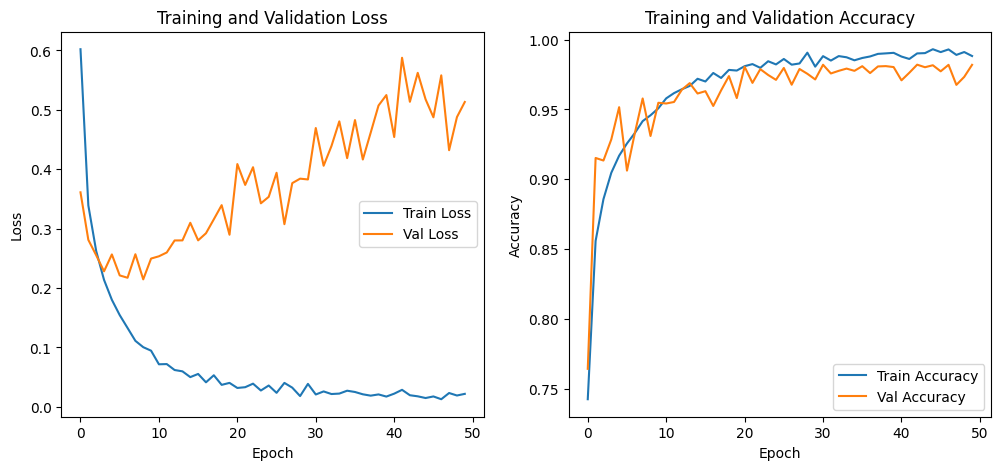

In [155]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [156]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.78      0.82      0.80       556
           2       0.94      0.95      0.95      1448
           3       0.56      0.84      0.67       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.85      0.92      0.88     21892
weighted avg       0.98      0.98      0.98     21892

